# COMP 534 - Applied Artificial Intelligence
## CA2 - Neural network regression
This notebook was produced as a deliverable for a group project for the above module, as part of the 2021-2022 Data Science and Artificial Intelligence MSc course at the University of Liverpool. It contains the design and optimisation of a neural network to solve a regression problem.
### Preparation
#### Setup
Import required libraries, tools and classifiers. Scikeras wrapper requires installation on colab.

In [6]:
pip install scikeras

In [111]:
# Data handling mathematical tools
import numpy as np
import pandas as pd

# Creating plots
import matplotlib.pyplot as plt
import seaborn as sns

# Monitor training progress
from time import perf_counter

# Data splitting and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Hyperparameter optimisation
# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Hyperparameter search
from sklearn.model_selection import GridSearchCV
# Performance evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Neural network
# NN wrapper for ease of handling
from scikeras.wrappers import KerasRegressor
# NN structure
from keras.models import Sequential
from keras.layers import Dense
# Loss functions
from tensorflow.keras import losses
# NN optimisers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
# Early stopping
from keras.callbacks import EarlyStopping

# Reduce tensorflow verbosity
from tensorflow import get_logger
get_logger().setLevel('ERROR')

# Set random seeds for reproducibility
np.random.seed(123)
from tensorflow.random import set_seed
set_seed(123)

#### Data
This analysis uses a dataset consisting of house sales in King County, USA. The aim is to predict sale price based on the available features. The dataset is available for download on Kaggle.  
https://www.kaggle.com/datasets/harlfoxem/housesalesprediction (last accessed 30/03/22)

In [9]:
df = pd.read_csv('kc_house_data.csv')

Show distribution of features:

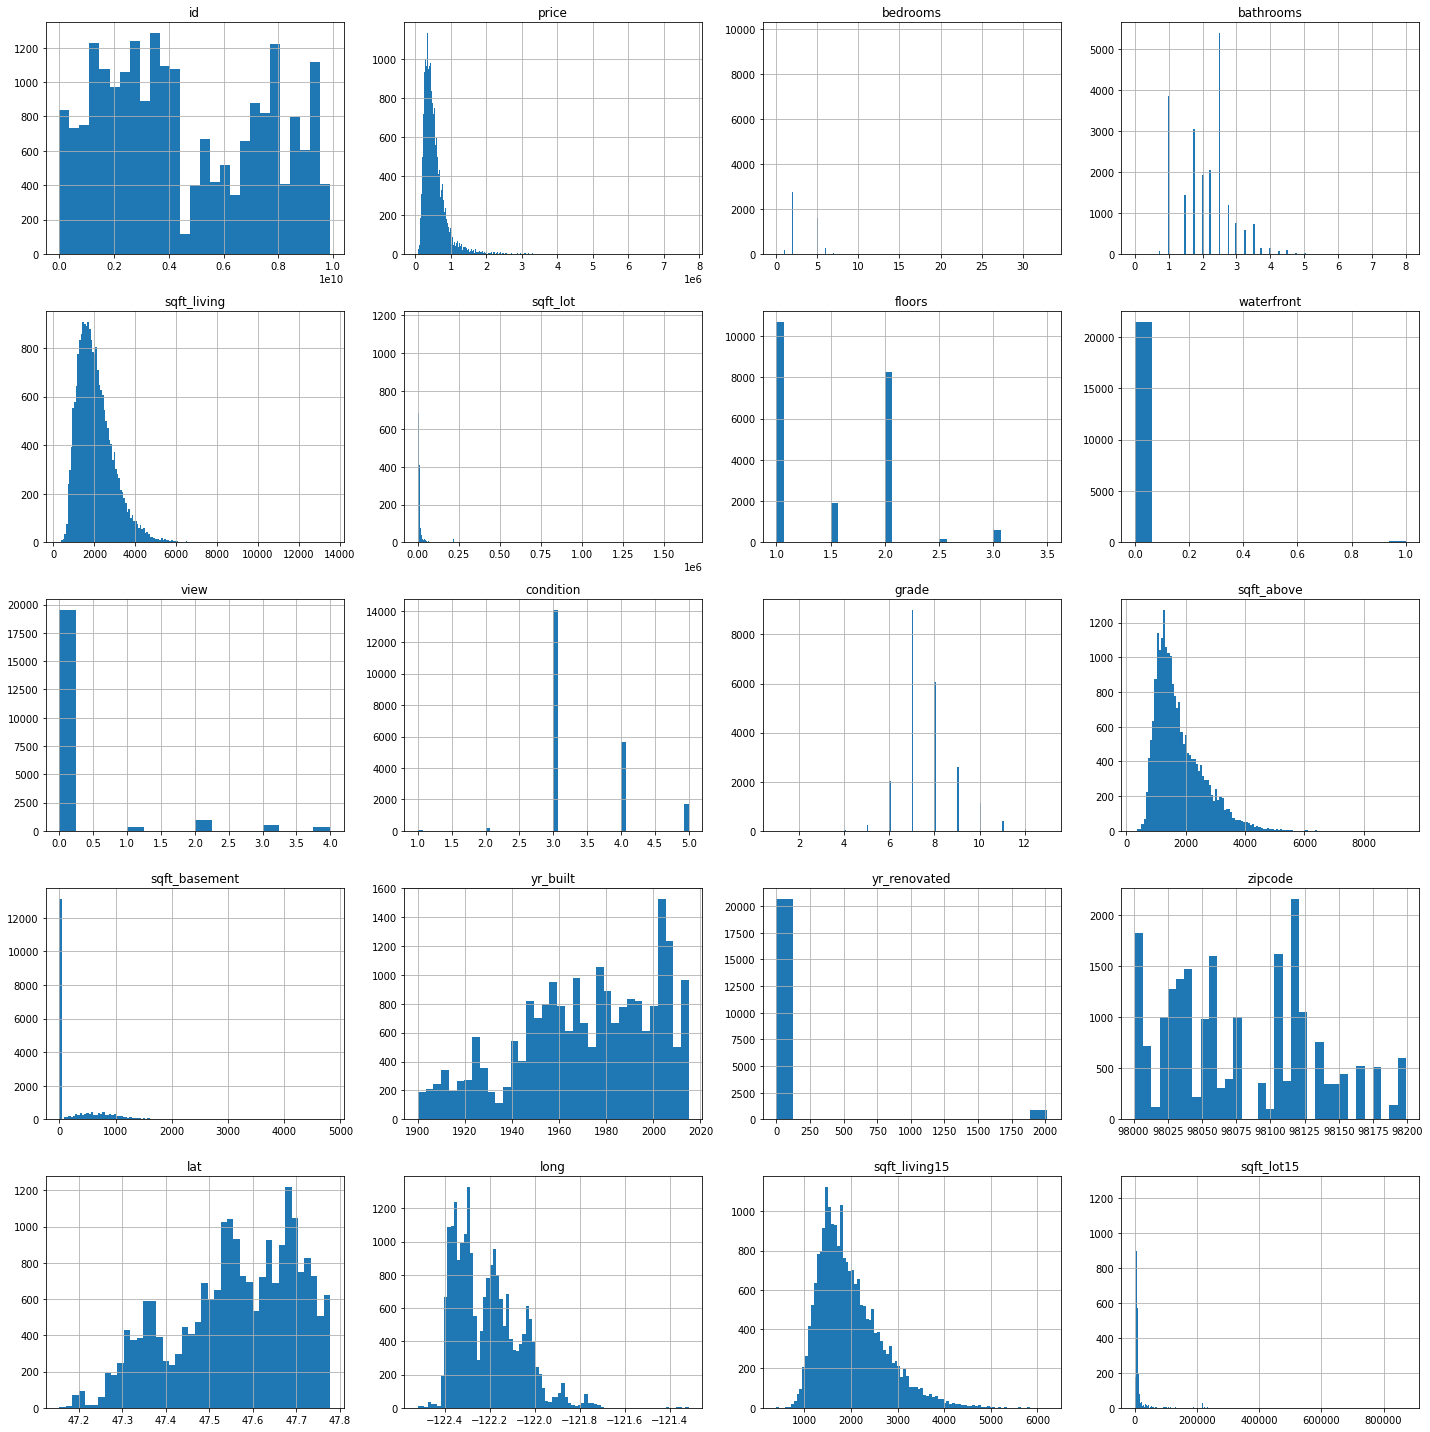

In [10]:
df.hist(figsize=(20,20), bins='auto')
plt.tight_layout()

#### Cleaning
Several cleaning steps are required before the dataset can be used to train a neural network.
##### Remove outliers
Several features have very large outliers which reduce model performance. These are removed.

In [11]:
originalRowCount = df.shape[0]
# Drop rows according to various conditions
df = df[(df['bedrooms'] > 0) & (df['bedrooms'] < 12)]
df = df[(df['bathrooms'] > 0) & (df['bathrooms'] < 12)]
df = df[df['sqft_lot'] < 5e5]
df = df[df['sqft_lot15'] < 3.5e5]
# Summary of impact on dataset
print(f'{((originalRowCount - df.shape[0])*100 / originalRowCount):.2f}% of rows removed')

0.22% of rows removed


This is an acceptable small proportion of the whole dataset.
##### Date
Date of sale can be used by turning it into a numerical variable.

In [12]:
# Cast date as datetime type
df['date'] = pd.to_datetime(df['date'])
# Create numerical variable as: difference between latest date in dataset and each other sale date
df['daysSinceSale'] = (df['date'].max() - df['date']).dt.days

##### Binning
The two features below contain mostly 0s and a small number of records with other values. The 0 values are still valid (no basement and never renovated) but could negatively impact performance. As a result this features will both be binned.

In [13]:
# Evenly bin all non 0 values and assign labels 1 - 10
bins = 9
df['basementOrdinal'] = pd.cut(df[df['sqft_basement']>0]['sqft_basement'], bins, labels=range(1, bins+1)).astype(int)
# Assign label of 0 to 0 values
df['basementOrdinal'] = df['basementOrdinal'].fillna(0)

In [14]:
# Evenly bin all non 0 values and assign labels 1 - 10
bins = 9
df['renovatedOrdinal'] = pd.cut(df[df['yr_renovated']>0]['yr_renovated'], bins, labels=range(1, bins+1)).astype(int)
# Assign label of 0 to 0 values
df['renovatedOrdinal'] = df['renovatedOrdinal'].fillna(0)

##### Transform skewed features
Several features are right skewed. These are natural log transformed to bring in the outliers and reduce their impact of model performance.

In [15]:
# List to hold skewed feature names
skewedVariables = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']
# List to hold new feature names
logVariables = ['priceLog', 'sqft_livingLog', 'sqft_lotLog', 'sqft_aboveLog', 'sqft_living15Log', 'sqft_lot15Log']
# Create new transformed features
df[logVariables] = np.log(df[skewedVariables])

##### Drop unused columns
Any remaining unused or superfluous columns are now removed.

In [16]:
# Drop original skewed features
df = df.drop(columns=skewedVariables)
# Drop features which have been replaced, along with id and zipcode
df = df.drop(columns=['date', 'id', 'sqft_basement', 'yr_renovated', 'zipcode',])

##### Move target price feature
Target variable moved to help when splitting it away from features.

In [17]:
# Remove target variable
feature = df.pop('priceLog')
# Reinsert at index 0
df.insert(0, 'priceLog', feature)

#### Splitting
The dataset is now ready to be split for use with the model. The features and target variable are separated.

In [18]:
# Create numpy array from pandas dataframe
data = df.values
# Create array of features
X = data[:, 1:]
# Create target array
y = data[:, 0].reshape(-1, 1)

Features and target variable are split into training and test set.

In [19]:
# 80% train and 20% test
# Data shuffled to reduce any bias in the order of the dataset
# Define random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    shuffle=True,
                                                    random_state=123,
                                                   )

There is a broad range of features across different scales. Some are normally distributed and others are binned labels. The features are normalised to account for this variation.

In [20]:
# Create min max scaler for features
featureScaler = MinMaxScaler()
# Fit to training data
featureScaler.fit(X_train)
# Normalise train and test features
X_train = featureScaler.transform(X_train)
X_test = featureScaler.transform(X_test)

Having been natural log transformed, the target variable is now normally distributed. This will be standardised to reduce the spread of values.

In [21]:
# Create standard scaler for target
targetScaler = StandardScaler()
# Fit to training data
targetScaler.fit(y_train)
# Standardise train and test target variable
y_train = targetScaler.transform(y_train)
y_test = targetScaler.transform(y_test)

Once predictions have been made using a model, it will be necessary to revert the predictions and target variable test values back to their original scale in order for informed conclusions to be drawn regarding model performance.

In [22]:
# Function to invert target variable (predicted or true values) to original form and reshape to 1 dimension for plotting
def targetReverter(data):
    return np.exp(targetScaler.inverse_transform(data).reshape(data.shape[0]))

### Model optimisation
#### Choice of loss function
The first hyperparameter that will be considered is the loss function. This is due to the fact that it will then be used as a key measure throughout the rest of the analysis. The two loss functions investigated here are mean squared error and mean absolute error. A relatively simple neural network will be used to produce results for comparison.

In [26]:
# NN with 2 hidden layers to compare loss functions
def lossModel(loss):
    # 2 hidden layers, 8 nodes each, relu activation function
    model = Sequential()
    model.add(Dense(units=8, input_shape=(18,),  activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    # Input loss function and SGD optimiser
    model.compile(loss=loss, optimizer='Adam')
    return model

Later hyperparameter optimisation will use kfold cross validation. However for the moment we will use a single additional validation split from the training set.

In [27]:
# 80% train and 20% validate
# Data shuffled to reduce any bias in the order of the dataset
# Define random state for reproducibility
X_trainValid, X_validate, y_trainValid, y_validate = train_test_split(X_train,
                                                                      y_train,
                                                                      test_size=0.20,
                                                                      shuffle=True,
                                                                      random_state=123
                                                                      )

Several trials are run using each loss function. They all undergo the same training process using some best initial estimates for other hyperparameters. For each trial, predictions are made against the validation set, and these are tested against the true values. Quality of predictions are scored using both MAE and MSE to enable comparison.

In [28]:
# Create models using selected loss functions
modelMSE = lossModel('mean_squared_error')
modelMAE = lossModel('mean_absolute_error')
# Store names for naming results
names = ['MSE', 'MAE']
# Revert true target values to original scale for later evaluation
revertValid = targetReverter(y_validate)
# Set trials to run
trials = 10
# Iterate over both models
for i, model in enumerate([modelMSE, modelMAE]):
    # Initialise arrays to hold error scores
    mse = np.zeros(trials)
    mae = np.zeros(trials)
    # Iterate over repeated trials
    for trial in range(trials):
        # Fit model to training data
        model.fit(X_trainValid,
                  y_trainValid,
                  epochs=100,
                  batch_size=32,
                  verbose=0,
                 )
        # Use trained model to make prediction on validation data
        y_validateLossPred = model.predict(X_validate)
        # Revert predictions to original scale
        revertPred = targetReverter(y_validateLossPred)
        # Store prediction scores
        mse[trial] = mean_squared_error(revertValid, revertPred, squared=False)
        mae[trial] = mean_absolute_error(revertValid, revertPred)
    # Print summary: scoring each method using both metrics
    print(f'Using {names[i]} loss function, achieved mean MSE: {(mse.mean()):.0f} with std: {(mse.std()):.0f}')
    print(f'Using {names[i]} loss function, achieved mean MAE: {(mae.mean()):.0f} with std: {(mae.std()):.0f}\n')

Using MSE loss function, achieved mean MSE: 124244 with std: 4810
Using MSE loss function, achieved mean MAE: 68964 with std: 2714

Using MAE loss function, achieved mean MSE: 127762 with std: 6309
Using MAE loss function, achieved mean MAE: 70408 with std: 3332



The two loss functions produce comparable results. It can be seen that MSE outperforms MAE using both evaluation metrics and is more consistent. As a result it will be used for the continuing model development.
#### Grid search optimisation: learning rate, batch size and optimiser
An exhaustive grid search will be performed to identify suitable values for these hyperparameters.

In [29]:
# Define search space
searchSpace = {
    'optimizer':[SGD, RMSprop, Adam], # SGD slow but kept for comparison
    'optimizer__learning_rate': [0.1, 0.01], # 0.001 removed, too slow training time
    'batch_size':[32, 64, 128],
}

Define neural network for use with the grid search.

In [30]:
# NN with 2 hidden layers
def gridSearchModel():
    # 2 hidden layers, 8 nodes each, relu activation function
    model = Sequential()
    model.add(Dense(units=8, input_shape=(18,),  activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    return model

##### Early stopping
To limit training time during the grid search, early stopping will be implemented, ending training when no improvement in the loss function is observed after a number of updates. Due to the training time, verbose settings were used to help monitor progress.

In [31]:
# Define early stopping, patience is number of consecutive updates which must show no improvement for early stopping to occur
earlyStop = EarlyStopping(monitor='loss', mode='min', verbose=2, patience=5)
# Use scikeras wrapper for compatibility with grid search
wrappedGridSearchModel = KerasRegressor(model=gridSearchModel,
                                        loss=losses.mean_squared_error,
                                        epochs=1000,
                                        verbose=0,
                                        callbacks=[earlyStop],
                                       )
# Define cross validation
kfold = KFold(n_splits=5)
# Create search, score each by MSE
hyperparameterSearch = GridSearchCV(wrappedGridSearchModel,
                                    searchSpace,
                                    scoring='neg_mean_squared_error',
                                    cv=kfold,
                                    verbose=2,
                                    )
# Perform search over searchSpace
searchResult = hyperparameterSearch.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Epoch 57: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.gradient_descent.SGD'>, optimizer__learning_rate=0.1; total time=  26.6s
Epoch 60: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.gradient_descent.SGD'>, optimizer__learning_rate=0.1; total time=  25.4s
Epoch 37: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.gradient_descent.SGD'>, optimizer__learning_rate=0.1; total time=  21.0s
Epoch 52: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.gradient_descent.SGD'>, optimizer__learning_rate=0.1; total time=  41.5s
Epoch 30: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.gradient_descent.SGD'>, optimizer__learning_rate=0.1; total time=  13.0s
Epoch 85: early stopping
[CV] END batch_size=32, optimizer=<class 'keras.optimizer_v2.gradient_descent.SGD'>, optimizer__learning_rate=0.01; tot

In [32]:
# Store best parameters found
optimumParameters = searchResult.best_params_
print(optimumParameters)
# Store all results in new dataframe
results = pd.DataFrame(searchResult.cv_results_)

{'batch_size': 32, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'optimizer__learning_rate': 0.01}


In [33]:
# Create long form of results for plotting
resultsLong = pd.melt(results,
                      id_vars=['param_batch_size', 'param_optimizer', 'param_optimizer__learning_rate'],
                      var_name='splitNumber',
                      value_name='MSE',
                      value_vars=['split0_test_score',
                                  'split1_test_score',
                                  'split2_test_score',
                                  'split3_test_score',
                                  'split4_test_score',
                                  ])
# Create new column with optimiser name for labels
resultsLong['optimiser'] = resultsLong['param_optimizer'].apply(lambda x: x.__name__)
# Rename learning rate column
resultsLong = resultsLong.rename(columns={'param_optimizer__learning_rate':'learningRate'})

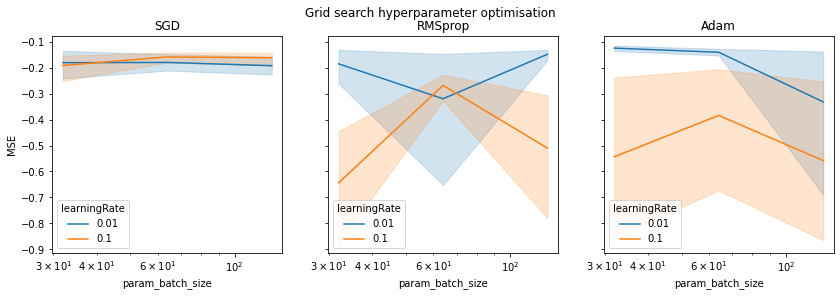

In [35]:
# Create figure for grid search results
fig, axs = plt.subplots(1, 3, figsize=(14,4), sharey=True)
# Plot results
for i, ax in enumerate(axs):
    sns.lineplot(ax=ax,
                data=resultsLong[resultsLong['optimiser'] == resultsLong['optimiser'].unique()[i]],
                x='param_batch_size',
                y='MSE',
                hue='learningRate',
                palette='tab10',
                )    
    # Set log axis and title
    ax.set(xscale='log')
    ax.set_title(resultsLong['optimiser'].unique()[i])
# Add title
fig.suptitle('Grid search hyperparameter optimisation', fontsize=12)
fig.savefig('gridSearchResults', bbox_inches='tight')
plt.show()

This grid search reveals considerable variation between different models' performance. The best MSE is achieved using the Adam optimiser, batch size of 32 and learning rate of 0.01. These values will be carried forward.
#### Neural network structure design: number of layers, nodes per layer and activation function
The final stage of model design optimisation will consider the structure of the network itself. A more flexible neural network is defined for use during this process. A tester function will be used to produce cross validation scores for each structure variant.

In [37]:
# NN taking input to define number of layers, nodes per hidden layer and hidden layer activation functions
def structureModel(hiddenLayers, nodes, actFunc):
    model = Sequential()
    model.add(Dense(units=nodes, input_shape=(18,),  activation=actFunc))
    # Add specified number of hidden layers
    for layer in range(hiddenLayers-1):
        model.add(Dense(units=nodes, activation=actFunc))
    # Output layer
    model.add(Dense(units=1, activation='linear'))
    # Use best performing optimiser and learning rate
    optimiser = Adam(learning_rate=0.01)
    model.compile(loss='mean_squared_error', optimizer=optimiser)
    return model

In [38]:
# Define function to test each neural network
def modelTester(testModel, splits):
    # Implement early stopping to limit training time
    earlyStop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    # Use scikeras wrapper for compatibility with cross validator
    wrappedStructureTestModel = KerasRegressor(model=testModel,
                                               epochs=1000,
                                               batch_size=32,
                                               verbose=0,
                                               callbacks=[earlyStop],
                                              )
    # Define cross validation
    kfold = KFold(n_splits=splits)
    # Train and perform cross validation, returning array of scores
    return cross_val_score(wrappedStructureTestModel, X_train, y_train, cv=kfold)

For flexibility, a custom grid search process will be employed to optimise network structure.

In [39]:
# Define search space
layers = [2, 3, 4]
nodes = [8, 16, 32]
actFuncs = ['relu', 'sigmoid']

The search output is made verbose in order to assist progress tracking.

In [40]:
# Create dataframe to store results
structureTestResults = pd.DataFrame(columns=['layers', 'nodes', 'activationFunction', 'split_1', 'split_2', 'split_3'])
# Set cross validation folds
splits=3
# Summary of upcoming search
print(f'{splits} folds for {len(layers)*len(nodes)*len(actFuncs)} model structures, totalling {splits*len(layers)*len(nodes)*len(actFuncs)} fits\n')
# Iterate over layer candidates
for layer in layers:
    # Iterate over node count candidates
    for node in nodes:
        # Iterate over activation function candidates
        for func in actFuncs:
            # Print current search candidate
            print(f'Structure: {layer} layers; {node} nodes per layer; {func} activation function')
            # Start timer
            startTime = perf_counter()
            # Create network with specific structure
            testModel = structureModel(layer, node, func)
            # Perform cross validation
            testResults = modelTester(testModel, splits)
            # End timer and print time taken for all folds of current candidate
            endTime = perf_counter()
            print(f'Time taken: {(endTime-startTime):.0f}s\n')
            # Identify current hyperparameters and add results
            hyperparameterList = [layer, node, func]
            hyperparameterList.extend(testResults)
            # Store details of current candidate in dataframe
            structureTestResults.loc[len(structureTestResults)]=hyperparameterList

3 folds for 18 model structures, totalling 54 fits

Structure: 2 layers; 8 nodes per layer; relu activation function
Epoch 55: early stopping
Epoch 33: early stopping
Epoch 33: early stopping
Time taken: 52s

Structure: 2 layers; 8 nodes per layer; sigmoid activation function
Epoch 86: early stopping
Epoch 72: early stopping
Epoch 161: early stopping
Time taken: 154s

Structure: 2 layers; 16 nodes per layer; relu activation function
Epoch 45: early stopping
Epoch 35: early stopping
Epoch 33: early stopping
Time taken: 52s

Structure: 2 layers; 16 nodes per layer; sigmoid activation function
Epoch 84: early stopping
Epoch 62: early stopping
Epoch 105: early stopping
Time taken: 127s

Structure: 2 layers; 32 nodes per layer; relu activation function
Epoch 49: early stopping
Epoch 33: early stopping
Epoch 57: early stopping
Time taken: 72s

Structure: 2 layers; 32 nodes per layer; sigmoid activation function
Epoch 116: early stopping
Epoch 104: early stopping
Epoch 105: early stopping
Tim

In [41]:
# Create long form of results for plotting
structureResultsLong = pd.melt(structureTestResults,
                        id_vars=['layers','nodes','activationFunction'],
                        var_name='splitNumber',
                        value_name='MSE',
                       value_vars=['split_1', 'split_2', 'split_3']) 

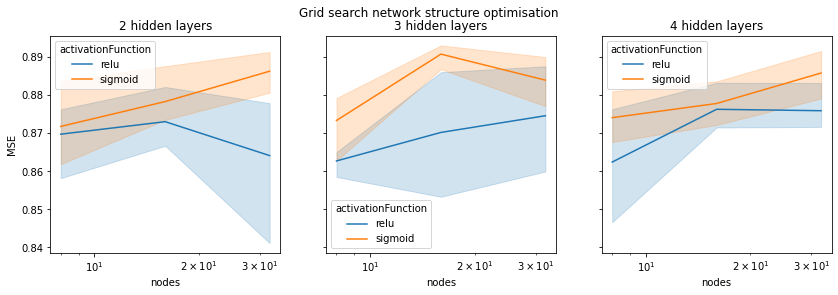

In [43]:
# Create figure for structure search results
fig, axs = plt.subplots(1, 3, figsize=(14,4), sharey=True)
# Iterate over axs
for i, ax in enumerate(axs):
    # Store current number of layers
    numberLayers = structureResultsLong['layers'].unique()[i]
    # Plot results
    sns.lineplot(ax=ax,
                data=structureResultsLong[structureResultsLong['layers'] == numberLayers],
                x='nodes',
                y='MSE',
                hue='activationFunction',
                palette='tab10',
                )    
    # Set log axis and titles
    ax.set(xscale='log')
    ax.set_title(f'{numberLayers} hidden layers')
# Add title
fig.suptitle('Grid search network structure optimisation', fontsize=12)
fig.savefig('structureSearchResults', bbox_inches='tight')
plt.show()

The variation in network structure shows less dramatic variation in performance. The relu activation function consistently outperforms sigmoid. This will be used, along with 3 hidden layers and 8 nodes per hidden layer.
#### Test Optimised Model
The final step is to create a model using our optimised hyperparameters. This will be used to predict the target variable using our unseen test data and the results compared against the true values.

In [100]:
# Create best model using identified hyperparameters
bestModel = structureModel(3, 8, 'relu')

Our validation set will be kept back again in order to employ early stopping to prevent overfitting.

In [101]:
# Define early stopping parameters
earlyStop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
# Fit model and store training loss
bestTraining = bestModel.fit(X_trainValid,
                             y_trainValid,
                             validation_data=(X_validate,
                                              y_validate),
                             epochs=1000,
                             batch_size=32,
                             verbose=0,
                             callbacks=[earlyStop]
                             )

Epoch 53: early stopping


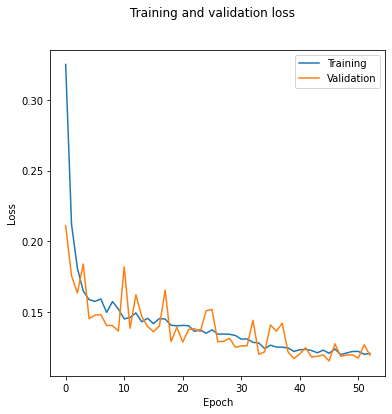

In [107]:
# Plot training process
fig, ax = plt.subplots(figsize=(6,6))
# Plot training and validation loss
ax.plot(bestTraining.history['loss'], label='Training')
ax.plot(bestTraining.history['val_loss'], label='Validation')
# Add legend, axis labels and title
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
fig.suptitle('Training and validation loss', fontsize=12)

fig.savefig('bestTrainValidateLoss', bbox_inches='tight')
plt.show()

The loss curve is particularly irregular for the validation set. However it can be seen to level off as early stopping occurs.
##### Test prediction
The model can now be used to predict against the test data.

In [108]:
# Make predictions against unseen test data
bestPred = bestModel.predict(X_test)
# Revert predictions and target test data to original scale
revertBestPred = targetReverter(bestPred)
reverty_test = targetReverter(y_test)

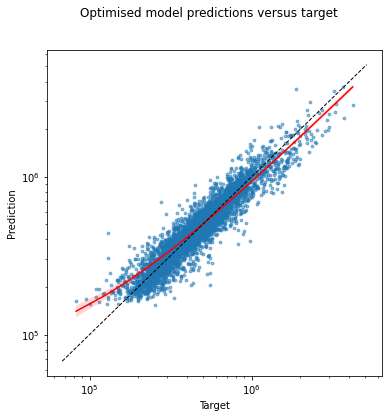

In [109]:
# Plot predictions against target variable
fig, ax = plt.subplots(figsize=(6,6))

ax = sns.regplot(x=reverty_test,
                 y=revertBestPred,
                 scatter_kws={'s':8,
                              'alpha':0.5
                              },
                 line_kws={'color':'red',
                           'linewidth':1.5
                           },
)
# Set log scale to bring in outliers
ax.set(xscale='log', yscale='log')
# Add x=y reference line
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=1)

# Add axis labels and title
ax.set_xlabel('Target')
ax.set_ylabel('Prediction')
fig.suptitle('Optimised model predictions versus target', fontsize=12)

fig.savefig('bestModelPredictionsTestComparison', bbox_inches='tight')
plt.show()

In [110]:
print(f'Model prediction versus target MSE: {mean_squared_error(reverty_test, revertBestPred, squared=False):.0f}')

Model prediction versus target MSE: 128879


From the plot of predictions versus test data we can get a picture of the model's performance. In general the behaviour of the target variable is well captured. However there is still considerable deviation and the MSE quantifies this. There are many potential areas for further work which could be investigated to improve on the results presented here, these will be discussed in the accompanying report.